The code from this notebook was largerly taken from:
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

We  are going to work with Book-Crossing dataset - a book ratings dataset to develop recommendation system algorithms.
Source : http://www2.informatik.uni-freiburg.de/~cziegler/BX/


Format
The Book-Crossing dataset comprises 3 tables.

- **BX-Users**

Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

- **BX-Books**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.

- **BX-Book-Ratings**

Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt

### Load and Preprocess Data

In [2]:
users = pd.read_csv('../Recommender_Systems_Surprise/data/BX-Users.csv', sep = ';',
                    error_bad_lines=False, encoding="latin-1")

users.columns = ['userID', 'Location', 'Age']
users.head(5)

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [3]:
print(users.shape)
users.isnull().sum()

(278858, 3)


userID           0
Location         0
Age         110762
dtype: int64

In [4]:
ratings = pd.read_csv("../Recommender_Systems_Surprise/data/BX-Book-Ratings.csv",
                      sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']
ratings.head(5)

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [5]:
print(ratings.shape)
ratings.isnull().sum()

(1149780, 3)


userID        0
ISBN          0
bookRating    0
dtype: int64

Lets merge these two columns

In [6]:
df = pd.merge(users, ratings, on="userID", how = "inner")
df.head(5)

userID                   Location   Age        ISBN  bookRating
0       2  stockton, california, usa  18.0  0195153448           0
1       7        washington, dc, usa   NaN   034542252           0
2       8   timmins, ontario, canada   NaN  0002005018           5
3       8   timmins, ontario, canada   NaN  0060973129           0
4       8   timmins, ontario, canada   NaN  0374157065           0

In [7]:
print(df.shape)
df.isnull().sum()

(1149780, 5)


userID             0
Location           0
Age           309492
ISBN               0
bookRating         0
dtype: int64

Since we don't really do NLP the column `Location` will only confuse the classifier, so we will drop it.
And we also have 25% of data missing in `Age` column. For now, we will also drop it, but later we should think about imputation strategy.

In [8]:
df = pd.merge(users, ratings, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


### EDA
Lets analyse how rating are distributed

In [10]:
df["bookRating"].value_counts().sort_index(ascending=False)

10     78610
9      67541
8     103736
7      76457
6      36924
5      50974
4       8904
3       5996
2       2759
1       1770
0     716109
Name: bookRating, dtype: int64

In [11]:
df["bookRating"].value_counts(normalize=True)

0     0.622823
8     0.090222
10    0.068370
7     0.066497
9     0.058743
5     0.044334
6     0.032114
4     0.007744
3     0.005215
2     0.002400
1     0.001539
Name: bookRating, dtype: float64

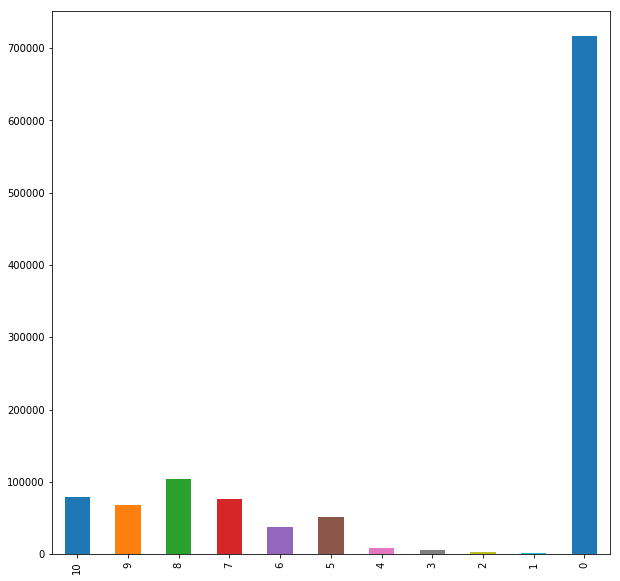

In [12]:
plt.figure(figsize=(10,10))
df["bookRating"].value_counts().sort_index(ascending=False).plot(kind="bar")

The majority of a ratings are 0's.

In [13]:
# Now will be interesting to observe how rating distributed w.r.t books

df.groupby('ISBN')['bookRating'].count().clip(upper=50)[:10]

ISBN
 0330299891    2
 0375404120    2
 0586045007    1
 9022906116    2
 9032803328    1
 9044922564    1
 9044922572    1
 9044922718    1
 9044923161    1
 904492401X    1
Name: bookRating, dtype: int64

In [16]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [17]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

We can observe that the majority of data has 0-4 amount of ratings, and only a few books have more. The mose rated one has 2502 ratings.

In [18]:
# Now let us observe how rating distributed w.r.t users

df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

In [19]:

# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Users hardly ever given more than 5 ratings, but there is one user who have given 13602 ratings (apparently, he reads quite a lot). The number of ratings per movie and the number of ratings per user decay exponentially. Therefore, in order to reduce computationla complexity, we can reduce the dimensionelity of the data. We are going to filter out rarely rated movies and rarely rating users.

In [20]:
# Recall the size of our data frame, before dim reduction
print('The original data frame shape: \t{}'.format(df.shape))

min_book_rating = 25
filtered_books = df['ISBN'].value_counts() > min_book_rating
print(filtered_books.shape)
filtered_books = filtered_books[filtered_books].index.tolist()

min_user_rating = 25
filtered_users = df['userID'].value_counts() > min_user_rating
print(filtered_users.shape)
filtered_users = filtered_users[filtered_users].index.tolist()

df_new = df[(df['ISBN'].isin(filtered_books)) & (df['userID'].isin(filtered_users))]

print('The new data frame shape: \t{}'.format(df_new.shape))

The original data frame shape: 	(1149780, 3)
(340556,)
(105283,)
The new data frame shape: 	(243579, 3)


In [21]:
df_new.head(5)

userID        ISBN  bookRating
353     242  0553278223          10
354     242  0971880107           0
394     243  0060915544          10
395     243  0060977493           7
397     243  0156006529           0

### Surprise
**Surprise** Documentation: https://surprise.readthedocs.io/en/stable/index.html

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.


In [22]:
reader = Reader(rating_scale = (0,9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [23]:
data

<surprise.dataset.DatasetAutoFolds instance at 0x7f3c0605eb00>

We use RMSE as our accuracy metric (offline) for the predictions

In [24]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [23]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [24]:
surprise_results

fit_time  test_rmse  test_time
Algorithm                                        
BaselineOnly       0.554936   3.405177   0.681340
CoClustering       2.984103   3.513812   0.571220
SVD                5.202761   3.558852   0.571037
SlopeOne           1.763797   3.563763   6.448906
KNNWithMeans       1.136690   3.570404   5.901506
KNNBaseline        1.566757   3.585101   7.010829
KNNWithZScore      1.285633   3.592030   6.373628
SVDpp            176.545859   3.806577   8.949649
KNNBasic           1.051398   3.863344   5.559122
NMF                5.761357   3.879794   0.606874
NormalPredictor    0.204762   4.747992   0.608170

Seems like **BaselineOnly** algorithms gives by far the smallets RMSE, therefore, we will proceed further with BaselineOnly and use Alternating Least Squares (ALS).

In [26]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{u'fit_time': (0.2301008701324463, 0.2737441062927246, 0.2749021053314209),
 u'test_rmse': array([3.40063413, 3.41010555, 3.39601784]),
 u'test_time': (0.6599400043487549, 0.5192768573760986, 0.6615710258483887)}

In [27]:
# Now proceed with train/test split

trainset, testset = train_test_split(data, test_size=0.3)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3921


3.392085934436437

To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [28]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [29]:
df.head()

uid         iid   rui       est                     details   Iu  Ui  \
0  72183  0671016768   0.0  2.228735  {u'was_impossible': False}   14  28   
1  62464  0140185216  10.0  3.890003  {u'was_impossible': False}   14  32   
2  49889  0064400077   0.0  1.878572  {u'was_impossible': False}   34  21   
3  91017  0553580191   0.0  2.540800  {u'was_impossible': False}   22  77   
4  63938  1400031699   0.0  0.000000  {u'was_impossible': False}  104  28   

        err  
0  2.228735  
1  6.109997  
2  1.878572  
3  2.540800  
4  0.000000

In [30]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [31]:
best_predictions

uid         iid  rui  est                     details   Iu   Ui  err
57237  217375  0553569910  0.0  0.0  {u'was_impossible': False}  330   70  0.0
31922  251394  0971880107  0.0  0.0  {u'was_impossible': False}   90  788  0.0
18393   93085  0425104273  0.0  0.0  {u'was_impossible': False}   80   17  0.0
12572  159376  0449001946  0.0  0.0  {u'was_impossible': False}   66   20  0.0
44939  198711  0440224829  0.0  0.0  {u'was_impossible': False}  568   36  0.0
44928  217375  0451409159  0.0  0.0  {u'was_impossible': False}  330   22  0.0
63186   23768  0671670646  0.0  0.0  {u'was_impossible': False}  424   36  0.0
44918  115120  0446364150  0.0  0.0  {u'was_impossible': False}  325   20  0.0
68791   98741  0671708635  0.0  0.0  {u'was_impossible': False}  312   76  0.0
18379  242824  0590466186  0.0  0.0  {u'was_impossible': False}  224   17  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 17 to 788, they are not really small, meaning that significant number of users have rated the target book.

In [32]:
worst_predictions

uid         iid   rui       est                     details   Iu  \
32456  200674  0679425268  10.0  0.013393  {u'was_impossible': False}  204   
43846   51386  0449221873  10.0  0.000000  {u'was_impossible': False}   40   
3313   266226  0156711427  10.0  0.000000  {u'was_impossible': False}  192   
34811   14521  0553275976  10.0  0.000000  {u'was_impossible': False}  204   
19046   49154  0385501412  10.0  0.000000  {u'was_impossible': False}   45   
53664  200674  0451160533  10.0  0.000000  {u'was_impossible': False}  204   
25704  115490  081297106X  10.0  0.000000  {u'was_impossible': False}  218   
25865   87555  0140043128  10.0  0.000000  {u'was_impossible': False}  256   
32005   43842  0451205448  10.0  0.000000  {u'was_impossible': False}  253   
7756    69042  0553286390  10.0  0.000000  {u'was_impossible': False}  157   

       Ui        err  
32456  18   9.986607  
43846  19  10.000000  
3313   26  10.000000  
34811  89  10.000000  
19046  11  10.000000  
53664  29  10.000000  
25704  55  10.000000  
25865   9  10.000000  
32005  18  10.000000  
7756   16  10.000000

The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "0553286390", the book was rated by 16 users, user "69042" rated 10, our BaselineOnly algorithm predicts 0.

In [36]:
df_new.loc[df_new['ISBN'] == '0553286390']['bookRating'].describe()

count    24.000000
mean      2.000000
std       3.833491
min       0.000000
25%       0.000000
50%       0.000000
75%       0.500000
max      10.000000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


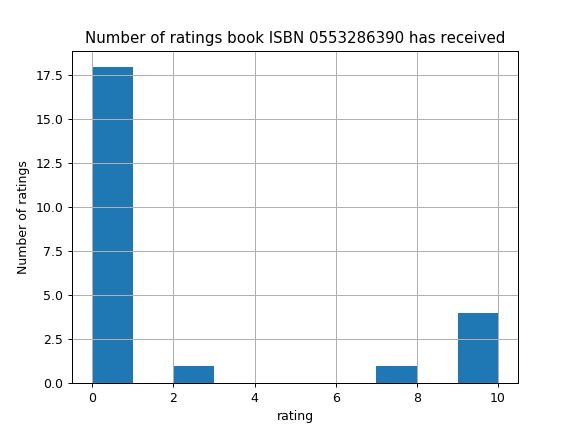

In [37]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '0553286390']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0553286390 has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only four users rated "10" and another rated '2' and '8'. Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.